In [2]:
from collections import Counter
import time

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sn
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T

from model import SAT
from util import CocoCaptionDataset

In [3]:
checkpoint_path = "logs/default/version_49/last.ckpt"

workers = 6

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SAT.load_from_checkpoint(checkpoint_path, map_location=device).to(device)
model.freeze()

valid_transforms = T.Compose([
    T.Resize(model.hparams.input_size),
    T.CenterCrop(model.hparams.input_size),
    T.ToTensor()
])
valid_ds = CocoCaptionDataset(jsonpath=model.hparams.json, split="test", transforms=valid_transforms)
val_loader = DataLoader(dataset=valid_ds, batch_size=model.hparams.batch, num_workers=workers,
                        persistent_workers=(True if workers > 0 else False), pin_memory=True)

In [4]:
headers = ["beamk", "temperature", "rescore_method", "rescore_reward", "bleu1", "bleu2", "bleu3", "bleu4", "cosine_similarity", "perplexity"]
results = pd.DataFrame(columns=headers)

In [13]:
beamks = [5]  # random Choice
temperatures = [0.7, 1.4]  # uniform sampling
methods = ["BAR"]  # random Choice, "NONE", "LN", "WR", "BAR"
# WR reward increase with beam
# BAR >1.0 is best for most beam
rewards = [0.5, 1.5]  # uniform sampling
iterations = 20  # Number of times to run the evaluation

In [14]:
# random grid search for N trials
t0 = time.time()
for n_iter in range(iterations):
    print(f"Start Iteration {n_iter+1} of {iterations}")

    # Sample the captioning parameters
    beamk = np.random.choice(beamks)
    temperature = np.random.uniform(temperatures[0], temperatures[1])
    method = np.random.choice(methods)
    reward = np.random.uniform(rewards[0], rewards[1])
    print(f"{beamk=}. {temperature=:.2f}. {method=}. {reward=:.2f}")

    row = {"beamk": beamk, "temperature": temperature, "rescore_method": method, "rescore_reward": reward}

    t1 = time.time()
    batch_metrics_total = Counter({})
    for batch_idx, batch in enumerate(val_loader):
        batch = [x.to(device) for x in batch]
        metrics = model.val_batch(batch, beamk=beamk, max_gen_length=32, temperature=temperature, rescore_method=method, rescore_reward=reward)
        batch_metrics_total += Counter(metrics)

        duration = time.time()-t1
        avg_duration = duration/(batch_idx+1)
        print(f"\rBatch {batch_idx+1}. Duration: {duration:.2f}s. Average Batch Time: {avg_duration:.2f}s.", end="")
        # if batch_idx+1>=2: break

    batch_metrics_avg = {k: v/(batch_idx+1) for k, v in batch_metrics_total.items()}
    row.update(batch_metrics_avg)
    results = results.append(row, ignore_index=True)

    print(f"\nFinish Iteration {n_iter+1} of {iterations}")

duration = time.time()-t0
print(f"Done. Total time={duration:.1f}s.")

Start Iteration 1 of 20
beamk=5. temperature=1.26. method='BAR'. reward=1.31
Batch 10. Duration: 130.49s. Average Batch Time: 13.05s.
Finish Iteration 1 of 20
Start Iteration 2 of 20
beamk=5. temperature=1.16. method='BAR'. reward=0.79
Batch 10. Duration: 130.90s. Average Batch Time: 13.09s.
Finish Iteration 2 of 20
Start Iteration 3 of 20
beamk=5. temperature=1.27. method='BAR'. reward=0.68
Batch 10. Duration: 131.13s. Average Batch Time: 13.11s.
Finish Iteration 3 of 20
Start Iteration 4 of 20
beamk=5. temperature=1.13. method='BAR'. reward=1.57
Batch 10. Duration: 130.60s. Average Batch Time: 13.06s.
Finish Iteration 4 of 20
Start Iteration 5 of 20
beamk=5. temperature=1.27. method='BAR'. reward=1.60
Batch 10. Duration: 130.68s. Average Batch Time: 13.07s.
Finish Iteration 5 of 20
Start Iteration 6 of 20
beamk=5. temperature=1.12. method='BAR'. reward=0.70
Batch 10. Duration: 130.64s. Average Batch Time: 13.06s.
Finish Iteration 6 of 20
Start Iteration 7 of 20
beamk=5. temperature=1

In [15]:
results.to_csv("data/results.csv", header=True, index=False)

In [16]:
results.sort_values(by="bleu4", ascending=False)

,beamk,temperature,rescore_method,rescore_reward,bleu1,bleu2,bleu3,bleu4,cosine_similarity,perplexity
21,5,1.104658,BAR,1.030953,0.636307,0.449545,0.318908,0.223100,0.691068,2.402018
17,5,1.101856,BAR,1.008440,0.636447,0.449581,0.318907,0.222979,0.690892,2.394864
9,5,1.120682,BAR,0.701850,0.634013,0.447834,0.318306,0.222909,0.688872,2.462798
15,5,1.116045,BAR,0.727701,0.634648,0.448229,0.318448,0.222879,0.689229,2.446753
18,5,1.119397,BAR,0.755855,0.634421,0.448085,0.318421,0.222717,0.689162,2.456072
0,5,1.123671,BAR,1.144963,0.633947,0.446471,0.316517,0.221161,0.690926,2.456480
5,5,1.163258,BAR,0.789189,0.632206,0.445878,0.316141,0.220836,0.688248,2.585941
11,5,1.149596,BAR,0.719382,0.632045,0.446042,0.316244,0.220818,0.687971,2.546680
16,5,1.163195,BAR,1.194154,0.632267,0.444329,0.314454,0.219570,0.690736,2.577660
12,5,1.250250,BAR,0.597953,0.626498,0.440607,0.313039,0.219520,0.684388,2.905901


In [17]:
results.columns

Index(['beamk', 'temperature', 'rescore_method', 'rescore_reward', 'bleu1',
       'bleu2', 'bleu3', 'bleu4', 'cosine_similarity', 'perplexity'],
      dtype='object')

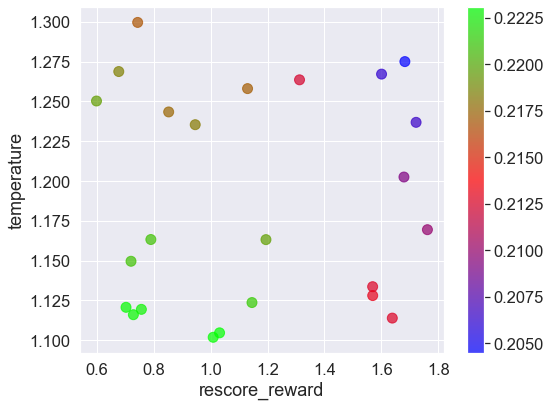

In [25]:
subset = results
fig = plt.figure(figsize=[8, 6])
ax = plt.gca()
# subset = subset[subset["beamk"]==20]
subset = subset[subset["rescore_method"]=="BAR"] #"NONE", "LN", "WR", "BAR"
# beamk, temperature, rescore_reward
x = "rescore_reward"
y = "temperature"
c = "bleu4"
im = ax.scatter(
    x=subset[x], y=subset[y],
    s=100, alpha=0.7,
    c=subset[c], cmap="brg",
)
fig.colorbar(im, ax=ax)
ax.set_xlabel(x)
ax.set_ylabel(y)
fig.tight_layout()

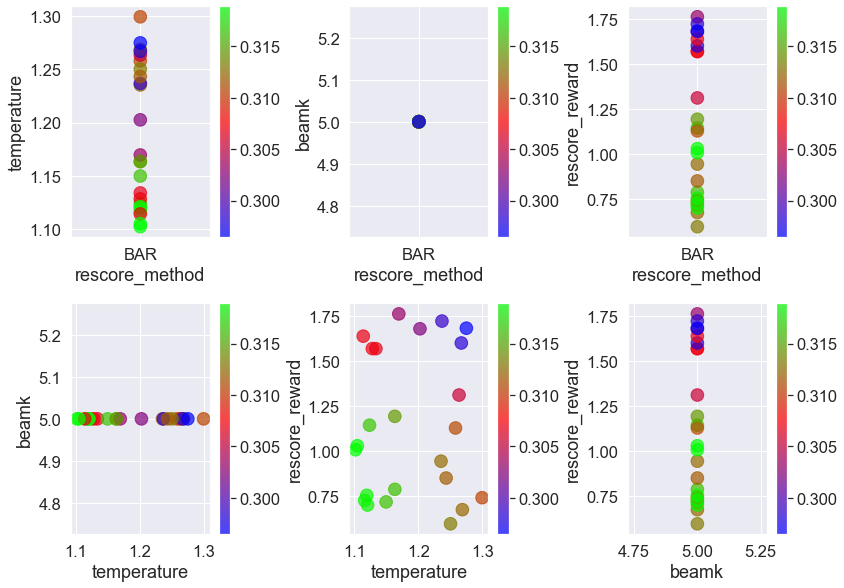

In [19]:
subset = results
# subset = subset[subset["beamk"]==5]
scale = 4
size = 40
color = "bleu3"
plots = [ # x, y, color
    ["rescore_method", "temperature", color],
    ["rescore_method", "beamk", color],
    ["rescore_method", "rescore_reward", color],
    ["temperature", "beamk", color],
    ["temperature", "rescore_reward", color],
    ["beamk", "rescore_reward", color],
]
rr = int(np.ceil(np.sqrt(len(plots)))) 
fig = plt.figure(figsize=[scale*rr, scale*rr])
for i, (x, y, c) in enumerate(plots):
    fig.add_subplot(rr, rr, i+1)
    ax = plt.gca()

    if "rescore_reward" in [x, y]:
        # Remove the
        df = subset[(subset["rescore_method"]!="NONE")&(subset["rescore_method"]!="LN")]
    else:
        df = subset

    im = ax.scatter(
        x=df[x], y=df[y],
        s=size*scale, alpha=0.7,
        c=df[c], cmap="brg",
    )
    fig.colorbar(im, ax=ax)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
fig.tight_layout()

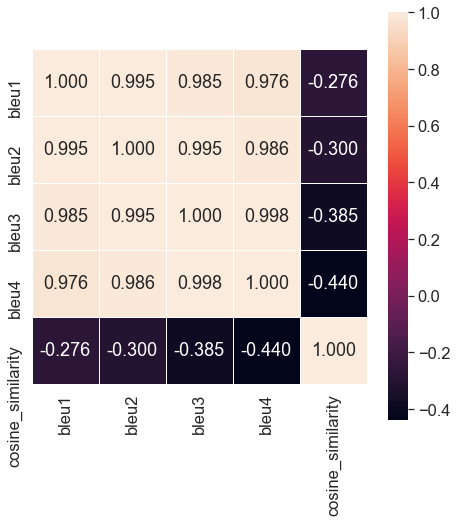

In [20]:
scale = 1.5
cols = ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'cosine_similarity']
data = results[cols].corr(method='pearson')
fig = plt.figure(figsize=(scale*len(cols), scale*len(cols)))
sn.set(font_scale=scale)  # Label size
ax = sn.heatmap(data,
    annot=True, fmt=".3f", annot_kws={"size": scale*12},
    # cmap='Blues',
    # vmin=0, vmax=1,
    xticklabels=cols,  yticklabels=cols,
    square=True, linewidths=0.5
)